# 📊 Data Preparation

## ⚙️ Setup 

### 📚 Importing Libraries

Importing from packages

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm
from pprint import pprint
import matplotlib.pyplot as plt
import torch
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from transformers import AutoTokenizer
from tokenizers import AddedToken
import plotly.express as px

/media/ishfar/New Volume/Studies/Projects/Kaggle-Automated-Essay-Scoring/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.chdir("../")

Importing user defined packages

In [3]:
from lib.utils.utils import seed_everything
from lib.config import config
from lib.paths import Paths
from lib.data import get_data_loaders, clean_text, sliding_window

### 🌱 Setting Random Seeds

In [4]:
seed_everything()

### 💽 Loading Data

In [5]:
train_df = pd.read_csv(Paths.TRAIN_CSV_PATH)
test_df = pd.read_csv(Paths.TEST_CSV_PATH)

train_df.shape, test_df.shape

((17307, 5), (3, 4))

## ⌛ Data Processing

Converting classes of scores to range from 0 to 5.

In [6]:
train_df["score"] = train_df["score"] - 1

Cleaning text.

In [7]:
train_df["full_text"] = train_df["full_text"].map(lambda x: clean_text(x))

## 🪙 Tokenizer

Sources:
1. [MOTH's Notebook](https://www.kaggle.com/code/alejopaullier/aes-2-multi-class-classification-train?scriptVersionId=170290107&cellId=14)

In [8]:
%env TOKENIZERS_PARALLELISM=true

env: TOKENIZERS_PARALLELISM=true


In [9]:
tokenizer = AutoTokenizer.from_pretrained(config.model)

/media/ishfar/New Volume/Studies/Projects/Kaggle-Automated-Essay-Scoring/venv/lib/python3.11/site-packages/transformers/convert_slow_tokenizer.py:550: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


[Idea of adding special tokens from Chris Deotte](https://www.kaggle.com/code/cdeotte/deberta-v3-small-starter-cv-0-820-lb-0-800?scriptVersionId=174239814&cellId=17)

In [10]:
tokenizer.add_tokens([AddedToken("\n", normalized=False)])
tokenizer.add_tokens([AddedToken(" "*2, normalized=False)])

1

In [11]:
tokenizer.save_pretrained(Paths.TOKENIZER_PATH)

('output/microsoft/deberta-v3-xsmall/tokenizer_v2/tokenizer_config.json',
 'output/microsoft/deberta-v3-xsmall/tokenizer_v2/special_tokens_map.json',
 'output/microsoft/deberta-v3-xsmall/tokenizer_v2/spm.model',
 'output/microsoft/deberta-v3-xsmall/tokenizer_v2/added_tokens.json',
 'output/microsoft/deberta-v3-xsmall/tokenizer_v2/tokenizer.json')

In [12]:
print(tokenizer)

DebertaV2TokenizerFast(name_or_path='microsoft/deberta-v3-xsmall', vocab_size=128000, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '[CLS]', 'eos_token': '[SEP]', 'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	1: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	128000: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	128001: AddedToken("
", rstrip=False, lstrip

## 🪟 Sliding Window

### Token Sequence Lengths before sliding window

In [13]:
lengths = [
    len(tokenizer(text, add_special_tokens=False)["input_ids"])
    for text in tqdm(train_df["full_text"].fillna(""), total=len(train_df))
]

100%|██████████| 17307/17307 [00:09<00:00, 1854.25it/s]


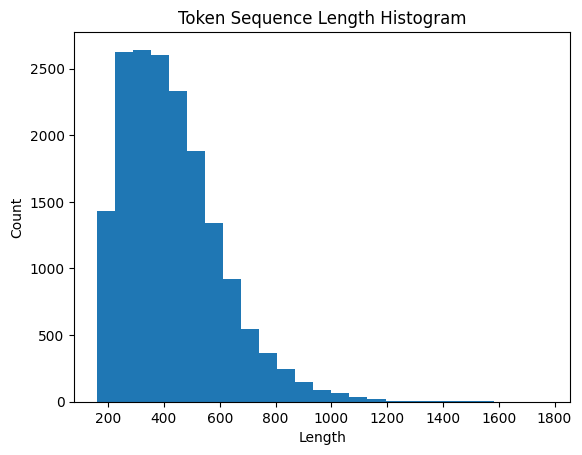

In [14]:
_ = plt.hist(lengths, bins=25)
plt.title("Token Sequence Length Histogram")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

Most sequences have length exceeding `config.max_length`. Instead of truncating and keeping only the first `config.max_length` tokens, I'll use sliding window.

1. In training, the model gets to see more data.
2. In inference, the model gets to the entire essay.

In [15]:
train_df = sliding_window(train_df, tokenizer)
train_df.shape

100%|██████████| 17307/17307 [00:31<00:00, 547.47it/s]


(23810, 5)

### Token Sequence Lengths after sliding window

In [16]:
lengths = [
    len(tokenizer(text, add_special_tokens=False)["input_ids"])
    for text in tqdm(train_df["full_text"].fillna(""), total=len(train_df))
]

100%|██████████| 23810/23810 [00:13<00:00, 1737.82it/s]


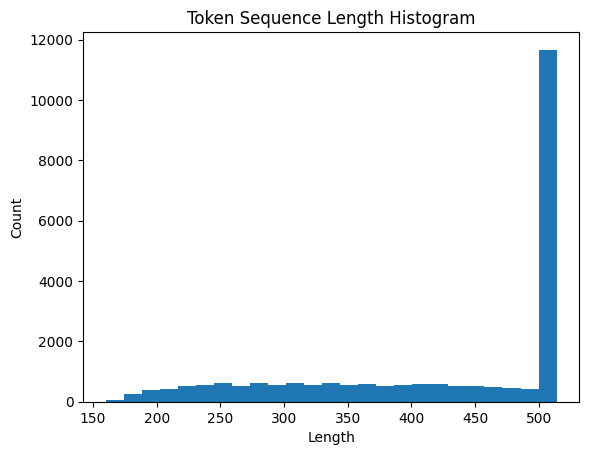

In [17]:
_ = plt.hist(lengths, bins=25)
plt.title("Token Sequence Length Histogram")
plt.xlabel("Length")
plt.ylabel("Count")
plt.show()

In [18]:
px.histogram(train_df, x="score", text_auto=True)

## ✂️ Train-Validation Splitting

Use `StratifiedGroupKFold` to split `train_df` into `Config.N_FOLDS`.

Sources
1. [MOTH's Notebook](https://www.kaggle.com/code/alejopaullier/aes-2-multi-class-classification-train?scriptVersionId=170290107&cellId=12)
2. [Martin's post](https://www.kaggle.com/competitions/learning-agency-lab-automated-essay-scoring-2/discussion/499959)

In [19]:
skf = StratifiedGroupKFold(n_splits=config.n_folds)

Seperate feature `X` and labels `y`.

In [20]:
X, y = train_df["full_text"], train_df["score"]
groups = train_df["topic"]

Assign fold number to dataframe `train_df`

In [21]:
train_df["fold"] = -1

for i, (train_idx, valid_idx) in enumerate(skf.split(X, y, groups=groups)):
    train_df.loc[valid_idx, "fold"] = i

Distribution of data across `config.n_folds`.

In [22]:
train_df["fold"].value_counts()

fold
0    4929
1    4017
4    3899
2    3463
6    3069
3    2603
5    1830
Name: count, dtype: int64

In [23]:
px.histogram(train_df, x="fold", color="score", text_auto=True, barmode="group")

## 🗃️ Torch Dataset

Sources
1. [MOTH's Notebook](https://www.kaggle.com/code/alejopaullier/aes-2-multi-class-classification-train?scriptVersionId=170290107&cellId=16)

In [24]:
if config.debug:
    train_fold = train_df[train_df["fold"] != 0].reset_index(drop=True)
    valid_fold = train_df[train_df["fold"] == 0].reset_index(drop=True)

    train_loader, valid_loader = get_data_loaders(train_fold, valid_fold, tokenizer)

    # === Let's check one sample ===
    for sample in train_loader:
        pprint(f"Encoding keys: {sample.keys()} \n")
        pprint(sample)
        break

Saving data loaders to disk.

In [25]:
def save_data_loaders(fold, train_fold, valid_fold, group=None):
    train_loader, valid_loader = get_data_loaders(train_fold, valid_fold, tokenizer)

    train_dataloader_name = f"train_{fold}.pth" if group is None else f"train_{fold}_{group}.pth"
    train_dataloader_path = os.path.join(Paths.DATA_LOADER_PATH, train_dataloader_name)
    torch.save(train_loader, train_dataloader_path)
    print(f"Saved {train_dataloader_path} with {len(train_fold)} samples ")

    valid_dataloader_path = os.path.join(Paths.DATA_LOADER_PATH, f"valid_{fold}.pth")
    torch.save(valid_loader, valid_dataloader_path)
    print(f"Saved {valid_dataloader_path} with {len(valid_fold)} samples ")

    valid_csv_path = os.path.join(Paths.DATA_LOADER_PATH, f"valid_{fold}.csv")
    valid_fold.to_csv(valid_csv_path, index=False)
    print(f"Saved {valid_csv_path}")

Splitting positive-negative randomly.

In [26]:
def get_sampled_train_df(train_df):
    positive_samples = train_df.loc[train_df.score.isin([0, 4, 5])].dropna()
    negative_samples = train_df.loc[train_df.score.isin([1, 2, 3])].dropna()

    for i, sampled_negative in enumerate(
        np.array_split(negative_samples, config.negative_sample_partitions)
    ):
        train_sampled_df = pd.concat([positive_samples, sampled_negative])
        yield i, train_sampled_df.sample(frac=1, random_state=config.random_seed)

Splitting positive-negative using `StratifiedKFold`.

In [29]:
# def get_sampled_train_df(train_df):
#     positive_samples = train_df.loc[train_df.score.isin([0, 4, 5])].dropna()
#     negative_samples = train_df.loc[train_df.score.isin([1, 2, 3])].dropna()

#     skf = StratifiedKFold(
#         n_splits=config.negative_sample_partitions,
#         shuffle=True,
#         random_state=config.random_seed,
#     )

#     for i, (_, valid_idx) in enumerate(
#         skf.split(negative_samples["full_text"], negative_samples["score"])
#     ):
#         train_sampled_df = pd.concat(
#             [
#                 positive_samples,
#                 negative_samples.iloc[valid_idx],
#             ]
#         )
#         yield i, train_sampled_df.sample(frac=1, random_state=config.random_seed)

In [30]:
if not os.path.exists(Paths.DATA_LOADER_PATH):
    os.makedirs(Paths.DATA_LOADER_PATH)

for fold in train_df.fold.unique():
    train_fold = train_df[train_df["fold"] != fold].reset_index(drop=True)
    valid_fold = train_df[train_df["fold"] == fold].reset_index(drop=True)

    if config.negative_sample:
        for i, train_sampled_df in get_sampled_train_df(train_fold):
            save_data_loaders(fold, train_sampled_df, valid_fold, i)
    else:
        save_data_loaders(fold, train_fold, valid_fold)

Saved data/dataloader_v4/train_2_0.pth with 9299 samples 
Saved data/dataloader_v4/valid_2.pth with 3463 samples 
Saved data/dataloader_v4/valid_2.csv
Saved data/dataloader_v4/train_2_1.pth with 9299 samples 
Saved data/dataloader_v4/valid_2.pth with 3463 samples 
Saved data/dataloader_v4/valid_2.csv
Saved data/dataloader_v4/train_2_2.pth with 9299 samples 
Saved data/dataloader_v4/valid_2.pth with 3463 samples 
Saved data/dataloader_v4/valid_2.csv
Saved data/dataloader_v4/train_3_0.pth with 9805 samples 
Saved data/dataloader_v4/valid_3.pth with 2603 samples 
Saved data/dataloader_v4/valid_3.csv
Saved data/dataloader_v4/train_3_1.pth with 9805 samples 
Saved data/dataloader_v4/valid_3.pth with 2603 samples 
Saved data/dataloader_v4/valid_3.csv
Saved data/dataloader_v4/train_3_2.pth with 9805 samples 
Saved data/dataloader_v4/valid_3.pth with 2603 samples 
Saved data/dataloader_v4/valid_3.csv
Saved data/dataloader_v4/train_0_0.pth with 8833 samples 
Saved data/dataloader_v4/valid_0.pth